# 4.2) 맛집 리뷰로 알아보는 "감성 분류"

In [69]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 카카오맵 리뷰 크롤링 

### 강남역 고기집을 검색!

![앱 생성 페이지](img/1.png)

-----

In [70]:
import os # 패지키 로드
# os.getcwd() ___ 현재 위치
set_path = 'C:/python'
os.chdir(set_path) # 절대 경로 설정

In [71]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re
import time

### 셀레니움으로 브라우저 열기

In [72]:
# 1. 윈도우용 크롬 웹드라이버 실행 경로 (Windows)
excutable_path = 'chromedriver.exe'

# 2. 크롤링할 사이트 주소를 정의합니다.
source_url = "https://map.kakao.com/"

# 3. 크롬 드라이버 사용
driver = webdriver.Chrome(executable_path=excutable_path)

# 4. url 접근
driver.get(source_url)

In [73]:
# Ctrl + Shift + I

# 검색어 입력(함수 update)
searchbox = driver.find_element("xpath","//input[@id='search.keyword.query']")
searchbox.send_keys("오목교 술집")

# 검색버튼으로 결과 가져오기
searchbutton = driver.find_element("xpath","//button[@id='search.keyword.submit']")
driver.execute_script("arguments[0].click();", searchbutton)
# arguments[0].click() 참조 : https://stackoverflow.com/questions/49871432/what-does-arguments0-and-arguments1-mean-when-using-executescript-method-fro

# 검색 결과를 가져올 시간을 기다립니다
time.sleep(2)

# 검색 결과의 페이지 소스를 가져옵니다
html = driver.page_source

# BeautifulSoup을 이용하여 html 정보를 파싱합니다
# BeautifulSoup(open("index.html"),"html.parser")
# "html.parser" : BeautifuㅣSoup 객체에게 "Html을 분석하라"고 명령
# 안 써도 상관은 없음
soup = BeautifulSoup(html, "html.parser")

# soup.find("p") : 처음 등장하는 p 태그 찾기
# soup.find_all("p") : 모든 p 태그 찾기
# 참조 url : https://homubee.tistory.com/20
moreviews = soup.find_all(name="a", attrs={"class":"moreview"})

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_urls = []
for moreview in moreviews:
    page_url = moreview.get("href")
    print(page_url)
    page_urls.append(page_url)

# 크롤링에 사용한 브라우저를 종료합니다.
driver.close()

https://place.map.kakao.com/906184805
https://place.map.kakao.com/926820662
https://place.map.kakao.com/1809357040
https://place.map.kakao.com/994345715
https://place.map.kakao.com/14710362
https://place.map.kakao.com/1830853465
https://place.map.kakao.com/615070189
https://place.map.kakao.com/621834264
https://place.map.kakao.com/24893867
https://place.map.kakao.com/677728327
https://place.map.kakao.com/27224207
https://place.map.kakao.com/2035022071
https://place.map.kakao.com/18826163
https://place.map.kakao.com/1121683246
https://place.map.kakao.com/27609311


-----

### 맛집 리뷰 정보 크롤링

![앱 생성 페이지](img/2.png)

-----

In [74]:
# 평점과 리뷰를 위한 데이터프레임 생성
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)

# 크롬 드라이버 사용
driver = webdriver.Chrome(executable_path=excutable_path)

# 데이터프레임 만들기
for page_url in page_urls:
    
    driver.get(page_url) # url 접근(상세보기 페이지)
    time.sleep(2)
    
    # 첫 페이지 리뷰를 크롤링합니다
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})
    
    rates = contents_div.find_all(name="em", attrs={"class":"num_rate"}) # 별점
    
    reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"}) # 리뷰
    
    for rate, review in zip(rates, reviews):
        row = [rate.text[0], review.find(name="span").text]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
    
    # 2-5페이지의 리뷰를 크롤링합니다
    for button_num in range(2, 6):
        # 오류가 나는 경우(리뷰 페이지가 없는 경우), 수행하지 않습니다.. 예외처리
        try:
            another_reviews = driver.find_element_by_xpath("//a[@data-page='" + str(button_num) + "']")
            another_reviews.click()
            time.sleep(2)
            
            # 페이지 리뷰를 크롤링합니다
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')
            contents_div = soup.find(name="div", attrs={"class":"evaluation_review"})

            rates = contents_div.find_all(name="em", attrs={"class":"num_rate"}) # 별점

            reviews = contents_div.find_all(name="p", attrs={"class":"txt_comment"}) # 리뷰

            for rate, review in zip(rates, reviews):
                row = [rate.text[0], review.find(name="span").text]
                series = pd.Series(row, index=df.columns)
                df = df.append(series, ignore_index=True)
        except:
            break    
driver.close()

In [75]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가합니다.
df['y'] = df['score'].apply(lambda x: 1 if float(x) > 3 else 0)
print(df.shape)
df.head()

(0, 3)


,score,review,y


In [58]:
df.to_csv("review_data.csv", index=False)

-----

# <Step2. 전처리> : TF-IDF를 이용한 핵심어 추출

### 1. 형태소 추출하기

#### 1) 한글 텍스트로 전처리

In [76]:
df = pd.read_csv("C:/python/review_data.csv")

In [77]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출합니다.
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # .. ch.2 참조
    result = hangul.sub('', text) # QQQ
    return result

In [79]:
# 함수를 적용하여 리뷰에서 한글만 추출합니다.)
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']

# 한 글자 이상의 텍스트를 가지고 있는 데이터만 추출합니다
df = df[df['ko_text'].str.len() > 0]
df.head()

,score,y,ko_text
1,4,1,녹는다 녹아
2,4,1,좋아요
3,5,1,흠잡을곳 없는 반찬이 정갈합니다
4,5,1,코로나 땜에 걱정했는데 방역수칙도 잘 지키시고 살치실이랑 등심 부드러워서 너무 좋아...
5,5,1,살치살 미쳤네요 대박입니다 퀄리티 굳이에요


-----

#### 2) 형태소 단위로 추출

In [80]:
from konlpy.tag import Okt

# 형태소/품사 형태로 데이터를 추출!
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 점검
result = get_pos(df['ko_text'].values[0])
print(result)

['녹는다/Verb', '녹아/Verb']


-----

### 2. 분류 모델의 학습 데이터로 변환하기

#### corpus(말뭉치) index 생성하기

raw 데이터셋 > 말뭉치 생성 > 학습 데이터셋 생성

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환합니다.
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x)) # tokenizer : 전처리 방식
X = index_vectorizer.fit_transform(df['ko_text'].tolist()) # fit_transform을 이용한 학습 데이터셋 생성

In [27]:
X.shape

(370, 2355)

In [28]:
# 점검
print(str(index_vectorizer.vocabulary_)[:100]+"..") # 말뭉치 생성

{'녹는다/Verb': 443, '녹아/Verb': 444, '좋아요/Adjective': 1900, '흠잡을/Adjective': 2346, '곳/Noun': 191, '없는/A..


In [29]:
print(df['ko_text'].values[0])
print(X[0]) # 443번, 444번 위의 피처가 1로 채워진 데이터로 바뀐 것을 확인할 수 있음!

녹는다 녹아
  (0, 443)	1
  (0, 444)	1


-----

#### TF-IDF로 변환

만약 데이터에 중복되는 형태소가 존재한다면? p.244

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X) # 학습 데이터셋 생성

In [32]:
print(X.shape)
print(X[0])

(370, 2355)
  (0, 444)	0.7071067811865475
  (0, 443)	0.7071067811865475


-----

# <Step3. 분류> : 긍정 부정 리뷰 분류하기

### 분류 모델링 .. Main!

#### 1. 데이터셋 분리

In [38]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # test_size : 테스트 데이터셋의 비율이나 갯수
# 자세한 설명은 .. https://blog.naver.com/PostView.naver?blogId=siniphia&logNo=221396370872

In [39]:
print(x_train.shape)
print(x_test.shape)

(259, 2355)
(111, 2355)


-----

#### 2. Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델 학습 .. Ch4_타이타닉과 같은 구조
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 모델평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.72
Precision : 0.663
Recall : 1.000
F1 : 0.797


교재에서는 전체적으로 수치가 매우 높아서 과적합이 의심되는 상황이지만 여기는,,?

-------

#### Confusion Matrix

과적합이 의심되는 경우

In [41]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[19 31]
 [ 0 61]]


In [44]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC?
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

AUC : 0.923


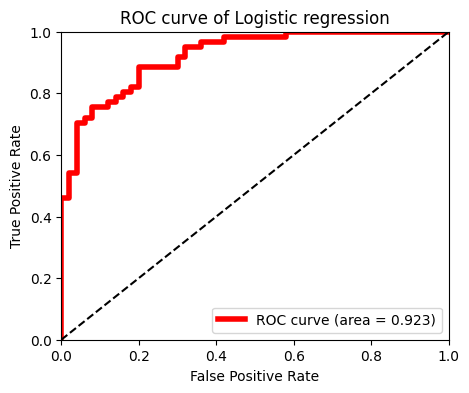

In [45]:
# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve of Logistic regression')

plt.legend(loc="lower right")

------

# <Step4. 활용> : 중요 키워드 분석

### 1. 회귀 모델의 피처 영향력 추출

<BarContainer object of 2355 artists>

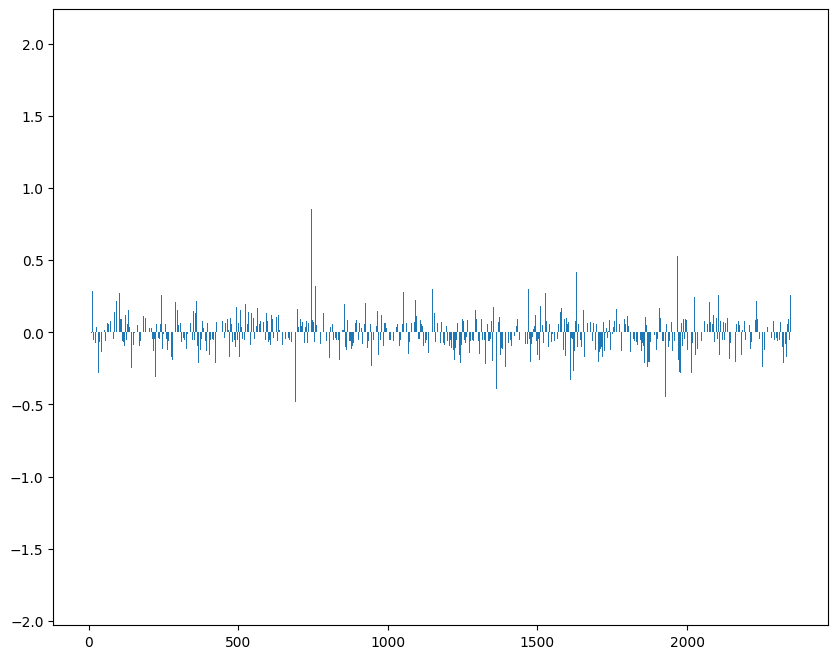

In [49]:
plt.rcParams['figure.figsize'] = [10, 8] # 크기

plt.bar(range(len(lr.coef_[0])), lr.coef_[0]) # 시각화

In [50]:
# 피처들의 계수 출력
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5]) # 내림차순 .. 앞 5개
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:]) # 뒤 5개

[(2.043669600241233, 2042), (1.4967402577292739, 1900), (0.8544040847017118, 745), (0.7853274965044353, 763), (0.6538494343347058, 773)]
[(-0.7181290402416206, 262), (-0.7336309109159104, 30), (-1.030539438168481, 1691), (-1.0909569407438633, 1011), (-1.835822517477161, 987)]


-----

### 2. 중요 피처의 형태소

In [52]:
# 위에서 봤던 내림차순으로 정렬한 계수들
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [54]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다.
print(str(invert_index_vectorizer)[:100]+'..')

{443: '녹는다/Verb', 444: '녹아/Verb', 1900: '좋아요/Adjective', 2346: '흠잡을/Adjective', 191: '곳/Noun', 1483:..


양수, 음수는 각각 긍정, 부정에 대응되므로 계수가 높은 것들일수록 맛집분류에 긍정적인 영향을 준 것들

In [56]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0]) # 단어 및 계수수치

최고/Noun 2.043669600241233
좋아요/Adjective 1.4967402577292739
맛있고/Adjective 0.8544040847017118
맛있어요/Adjective 0.7853274965044353
맛있음/Adjective 0.6538494343347058
직원/Noun 0.5302487977977177
친절하고/Adjective 0.49466978920091315
도/Josa 0.4944788280527659
좋은/Adjective 0.4559662723183862
깔끔하고/Adjective 0.4535617256366889
곱/Noun 0.4363532283197378
음식/Noun 0.4294078308045008
육즙/Noun 0.41429985716378287
과/Josa 0.41205647166926224
추천/Noun 0.4067258285617973
존맛/Noun 0.40365389533842727
좋습니다/Adjective 0.39532173137784077
양도/Noun 0.37469639925709736
맛있게/Adjective 0.3689514722452216
꽃/Noun 0.35863671880687314


In [57]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

비추/Verb -0.41105552638431475
못/VerbPrefix -0.42256154352836217
거의/Noun -0.43190055478705325
ㅠㅠ/KoreanParticle -0.439140351976497
주문/Noun -0.4467787704460249
말/Noun -0.4686585133886664
없고/Adjective -0.47030184135267455
하지/Verb -0.47418498714883783
마세요/Verb -0.47961721561547555
그/Determiner -0.5096436648976742
에/Josa -0.5424222711170605
좀/Noun -0.6100370017539678
을/Josa -0.6424787719822685
아쉬워요/Adjective -0.6738943451753576
은/Josa -0.6859416561443857
그냥/Noun -0.7181290402416206
가/Josa -0.7336309109159104
이에요/Josa -1.030539438168481
보통/Noun -1.0909569407438633
별로/Noun -1.835822517477161


-----

### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 

In [61]:
noun_list = [] # 명사가 들어갈 리스트
adjective_list = [] # 형용사가 들어갈 리스트

In [66]:
# 각각의 상위 10개 형태소 출력
for coef in coef_pos_index[:100]:
    pos_category = invert_index_vectorizer[coef[1]].split("/")[1] # "/"로 품사별 형태소 추출
    if pos_category == "Noun":
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif pos_category == "Adjective":
        adjective_list.append((invert_index_vectorizer[coef[1]], coef[0]))

In [63]:
# 상위 10개의 명사
noun_list[:10]

[('최고/Noun', 2.043669600241233),
 ('직원/Noun', 0.5302487977977177),
 ('곱/Noun', 0.4363532283197378),
 ('음식/Noun', 0.4294078308045008),
 ('육즙/Noun', 0.41429985716378287),
 ('추천/Noun', 0.4067258285617973),
 ('존맛/Noun', 0.40365389533842727),
 ('양도/Noun', 0.37469639925709736),
 ('꽃/Noun', 0.35863671880687314),
 ('냉면/Noun', 0.35345340377864076)]

In [65]:
# 상위 10개의 형용사
adjective_list[:10]

[('좋아요/Adjective', 1.4967402577292739),
 ('맛있고/Adjective', 0.8544040847017118),
 ('맛있어요/Adjective', 0.7853274965044353),
 ('맛있음/Adjective', 0.6538494343347058),
 ('친절하고/Adjective', 0.49466978920091315),
 ('좋은/Adjective', 0.4559662723183862),
 ('깔끔하고/Adjective', 0.4535617256366889),
 ('좋습니다/Adjective', 0.39532173137784077),
 ('맛있게/Adjective', 0.3689514722452216),
 ('맛있는데/Adjective', 0.3088119150668726)]